# Import libraries & Open directory

### Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import random
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython import display
import time
from pathlib import Path
import pandas as pd
import os
import copy
import networkx as nx
import pickle
import sys
from scipy import stats
%matplotlib inline

# change directory

os.chdir("/home/kyoko/Develop/ActualCausation/MABE/MABE_contents/actual_agency")

# import packages -- pyphi

from pyanimats import *
from pyTPM import *
import actual_agency as agency
import pyphi
from pyphi import actual, config, Direction

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:
# Change directory back to Example directory, now in MABE_contents
os.chdir("../Experiments/analysis_now")

In [3]:
%load_ext autoreload
%autoreload 2
%aimport pyTPM, pyanimats, actual_agency

# Make an array to contain data

In [4]:
datas = np.zeros(3000).reshape(250, 12)

prearr = np.sort(np.tile(np.arange(1,11), (1,5))).reshape(50, 1) 
runarr = np.tile(prearr.copy(), (5,1)) #Runs
hidarr = np.sort(np.tile(np.arange(2,7), (1,50))).reshape(250, 1) #Hidden nodes
stsarr = np.tile(np.arange(1,6), (1,50)).reshape(250, 1)

datas[:,0:1] = hidarr
datas[:,1:2] = runarr
datas[:,2:3] = stsarr

print(datas)

[[ 2.  1.  1. ...  0.  0.  0.]
 [ 2.  1.  2. ...  0.  0.  0.]
 [ 2.  1.  3. ...  0.  0.  0.]
 ...
 [ 6. 10.  3. ...  0.  0.  0.]
 [ 6. 10.  4. ...  0.  0.  0.]
 [ 6. 10.  5. ...  0.  0.  0.]]


# setting

In [5]:
# defining some parameters to use 
generations = 30000
n_agents = int(generations/500.+1)
n_runs = 10
n_trials = 64

run = 1 # 0 ~ n_runs-1
agent = 60 # saved generation
trial = 60 # 0~63
transition = 30 # state time 0~34

In [6]:
# Get Line-of-descent (LOD) data from MABE output

with open('190822_7156331_h2_LOD_data.pkl','rb') as f:
    LOD_data2 = pickle.load(f)
with open('190822_7156331_h3_LOD_data.pkl','rb') as f:
    LOD_data3 = pickle.load(f) 
with open('190822_7156331_h4_LOD_data.pkl','rb') as f:
    LOD_data4 = pickle.load(f)
with open('190822_7156331_h5_LOD_data.pkl','rb') as f:
    LOD_data5 = pickle.load(f)
with open('190822_7156331_h6_LOD_data.pkl','rb') as f:
    LOD_data6 = pickle.load(f)

In [7]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print(cwd)

/home/kyoko/デスクトップ/Develop/ActualCausation/MABE/MABE_contents/Experiments/analysis_now


# Get fitness

In [25]:
# add fitness to the LOD data structure

for n in range(n_runs):
    LOD_data2[n]['fitness'] = (LOD_data2[n]['correct_AVE']
                               /(LOD_data2[n]['correct_AVE']+LOD_data2[n]['incorrect_AVE']))
    print(LOD_data2[n]['fitness'][60])

0.8515625
0.8203125
0.84375
0.75
0.90625
0.765625
0.875
0.8125
0.703125
0.828125


# Get genome data

In [9]:
# Get the genome from our output
with open('190822_7156331_h2_genome.pkl','rb') as f:
    all_genomes2 = pickle.load(f)
with open('190822_7156331_h3_genome.pkl','rb') as f:
    all_genomes3 = pickle.load(f)
with open('190822_7156331_h4_genome.pkl','rb') as f:
    all_genomes4 = pickle.load(f)
with open('190822_7156331_h5_genome.pkl','rb') as f:
    all_genomes5 = pickle.load(f)
with open('190822_7156331_h6_genome.pkl','rb') as f:
    all_genomes6 = pickle.load(f)

In [31]:
# we can pick the genome of one agent and parse it (make it readable for our scripts) 
genome= agency.get_genome(all_genomes2, run, agent)

# from the genome we can reconstruct the TPM (transition probability matrix) and CM (connectivity matrix)
TPM, TPM_gates, cm = genome2TPM(genome, n_nodes=6, n_sensors=2, n_motors=2, gate_type='deterministic',states_convention='loli',remove_sensor_motor_effects=True)


# Get activity data 

In [11]:
# First get the data from our MABE output
with open('190822_7156331_h2_activity.pkl','rb') as f:
    activity = pickle.load(f)

In [12]:
# reformat the activity to a single list for each trial
brain_activity = []
for r in range(n_runs):
    brain_activity.append(agency.getBrainActivity(activity[r],n_agents=n_agents, n_nodes=6, n_hidden=2))

Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...


## state

In [13]:
# find the most frequent state
from collections import Counter

def counting3(data):
    c = Counter(data)
    freq_scores = c.most_common()
    third_count = freq_scores[2][1] #結局3つ目までとるので問題は3つ目のみ
    
    modes = [freq_scores[0][:], freq_scores[1][:]]
    for p in range(2,len(freq_scores)): #出現回数を比較、追加
        if freq_scores[p][1] == third_count:
            modes.append(freq_scores[p])
    return(modes)

def int2binary(n,nodes):
    holi = [int(x) for x in bin(n)[2:].zfill(nodes)]
    holi.reverse()
    return tuple(holi)

In [14]:
dec = []

#for i in range(0, n_runs): #all runs
actarr = brain_activity[run][agent][trial]
    
for j in range(0,35): # 2進法 -> 10進法変換 行35,列node数の行列 
    num = 0
    for k in range(len(brain_activity[0][0][0][0])):
        num = num + (2 ** k) * actarr[j][k] 
        num = int(num) # 2進法への変換のためfloat -> int型
    dec.append(num)

# 10進法の数値の入ったarray(数, 回数)
c = Counter(dec)
prestate = counting3(dec)
print(prestate)

[(20, 24), (56, 4), (0, 1), (52, 1), (57, 1), (47, 1), (19, 1), (42, 1), (24, 1)]


In [28]:
len(brain_activity[0][0])

64

In [15]:
state = []
for i in range(len(prestate)):
    state.append(int2binary(prestate[i][0],6)) #change

## network from cm, TPM

In [16]:
# define network for this animat change
network = pyphi.network.Network(np.array(TPM), cm=np.array(cm), 
            node_labels=tuple(['S1','S2','M1','M2','H1','H2']), purview_cache=None)

# Culculate phi

In [17]:
# all network of animats; if there is a node not has input and output -> 0

for i in range(len(state)):
    subsystem = pyphi.Subsystem(network, state[i], nodes=(4,5))
    Phi = pyphi.compute.phi(subsystem)
    print("state%d's phi is %d"%(i, Phi))

state0's phi is 0
state1's phi is 0
state2's phi is 0
state3's phi is 0
state4's phi is 0
state5's phi is 0
state6's phi is 0
state7's phi is 0
state8's phi is 0


In [18]:
# all possible cut. Are there any irreducible structures within the animat?
complexes = pyphi.compute.network.complexes(network,state[0])


In [19]:
print('all phis are',[complexes[i].phi for i in range(len(complexes))])
print('subsystems are', complexes[0].subsystem)

all phis are []


IndexError: list index out of range

# Structure of nodes

/home/kyoko/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/envs/pyphikit/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kyoko/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/envs/pyphikit/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


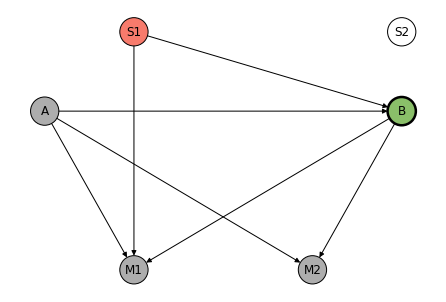

In [20]:
agency.plot_brain(cm)

In [21]:
state

[(0, 0, 1, 0, 1, 0),
 (0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 0, 0),
 (0, 0, 1, 0, 1, 1),
 (1, 0, 0, 1, 1, 1),
 (1, 1, 1, 1, 0, 1),
 (1, 1, 0, 0, 1, 0),
 (0, 1, 0, 1, 0, 1),
 (0, 0, 0, 1, 1, 0)]

In [22]:
# stateをdatasに格納
for i in range(len(state)):
    if i < 5:
        datas[(run-1)*5 + i][3] = prestate[i][0]

np.set_printoptions(threshold = 10000)
datas

array([[ 2.,  1.,  1., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  2., 56.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  4., 52.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  5., 57.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  5.,  0.,  0.,  